# <center>Analyse daily meassurements from HRV Logger App<center>
### <center>Databasis: feature computation from app<center>

In [1]:
import pandas as pd
from csv_prepare import csv_cp
from create_df import read_df
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so

# <center> User Input <center>

In [2]:
# select which measurements to show
select_measurement = ['ot_m', 'ot_a']   #so far just 2 sets are selectable
plt_select_length = 4                   #select at which character the measurements are divided for the plot

## Obsidian related plots ##
windowframe = '7D' # select how many days to show
select_rolling = 15 # select number of measurements for rolling median calculation

## <center> Setup Dataframes <center>

### Import data from filesystem

In [3]:
# copy files to workdir, create column measurement, format timestamp
csv_cp()

#create initial dataframe
df = read_df()

# add date column to df
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

### Setup individual dataframes

In [56]:
# dataframes per measurement
select_measurement_idx0 = df[df['measurement'].str.contains(select_measurement[0])]
select_measurement_idx0 = select_measurement_idx0.sort_values('measurement')
select_measurement_idx1 = df[df['measurement'].str.contains(select_measurement[1])]
select_measurement_idx1 = select_measurement_idx1.sort_values('measurement')

# select last measurement
idx0_lastMeasurement = df[df['measurement'].str.contains(select_measurement_idx0.sort_values('measurement')['measurement'].unique()[-1])]
idx1_lastMeasurement = df[df['measurement'].str.contains(select_measurement_idx1.sort_values('measurement')['measurement'].unique()[-1])]

# grouped dataframes, used in calculate rolling values
gpDate_select_measurement_idx0 = select_measurement_idx0.groupby('date').median()
gpDate_select_measurement_idx0['rol_rmssd'] = gpDate_select_measurement_idx0['rmssd'].rolling(select_rolling).median()
gpDate_select_measurement_idx0['rol_hr'] = gpDate_select_measurement_idx0['hr'].rolling(select_rolling).median()

gpDate_select_measurement_idx1 = select_measurement_idx1.groupby('date').median()
gpDate_select_measurement_idx1['rol_rmssd'] = gpDate_select_measurement_idx1['rmssd'].rolling(select_rolling).median()
gpDate_select_measurement_idx1['rol_hr'] = gpDate_select_measurement_idx1['hr'].rolling(select_rolling).median()

# dataframes for heatmap
corr_idx0 = pd.DataFrame(select_measurement_idx0)
corr_idx0 = corr_idx0.drop([
    'artifacts',
    'time',
    'measurement',
    'date',
    'datapoint'],axis=1)
corr_idx0.reset_index()

corr_idx1 = pd.DataFrame(select_measurement_idx1)
corr_idx1 = corr_idx1.drop([
    'artifacts',
    'time',
    'measurement',
    'date',
    'datapoint'],axis=1)
corr_idx1.reset_index()

# all measurements, long format, grouped by date, select column for plot
gp_MesDt = df.groupby(['measurement', 'date']).median()[['hr', 'rmssd']]
gp_MesDt.reset_index(drop= False, inplace= True)
gp_MesDt = gp_MesDt[gp_MesDt['measurement'].str.contains('|'.join(select_measurement))]
gp_MesDt['plt_select'] = gp_MesDt['measurement'].str[:plt_select_length]

# create filter last 7 days, group by date
plt_df_1 = pd.DataFrame(gp_MesDt[gp_MesDt['measurement'].str.contains(select_measurement[0])])
plt_df_1.set_index('date', drop= True, inplace= True)
plt_df_1 = plt_df_1.last(windowframe)
plt_df_1.reset_index(drop= False, inplace= True)
plt_df_1 = pd.merge(plt_df_1,
                    gpDate_select_measurement_idx0[['rol_hr', 'rol_rmssd']],
                    on= 'date',
                    how= 'left')

plt_df_2 = pd.DataFrame(gp_MesDt[gp_MesDt['measurement'].str.contains(select_measurement[1])])
plt_df_2.set_index('date', drop= True, inplace= True)
plt_df_2 = plt_df_2.last(windowframe)
plt_df_2.reset_index(drop= False, inplace= True)
plt_df_2 = pd.merge(plt_df_2,
                    gpDate_select_measurement_idx1[['rol_hr', 'rol_rmssd']],
                    on= 'date',
                    how= 'left')

plt_df = pd.concat([plt_df_1, plt_df_2])
plt_df.reset_index(drop=True, inplace=True)

## check if all measurements are imported

In [5]:
print('Morgenroutine: ', 
      select_measurement_idx0.sort_values('measurement')['measurement'].unique()[-1],
      '|', 
      len(select_measurement_idx0.sort_values('measurement')['measurement'].unique()),
      '|',
      select_measurement_idx0['time'].iloc[-1].day,'-',select_measurement_idx0['time'].iloc[-1].month,'-',select_measurement_idx0['time'].iloc[-1].year)

print('Abendroutine:  ', 
      select_measurement_idx1.sort_values('measurement')['measurement'].unique()[-1],
      '|', 
      len(select_measurement_idx1.sort_values('measurement')['measurement'].unique()),
      '|',
      select_measurement_idx1['time'].iloc[-1].day,'-',select_measurement_idx1['time'].iloc[-1].month,'-',select_measurement_idx1['time'].iloc[-1].year)

Morgenroutine:  ot_m83 | 80 | 4 - 3 - 2023
Abendroutine:   ot_a82 | 72 | 4 - 3 - 2023


# <center> Print <center>

## set styling for all plots

In [6]:
sns.set_theme(style= 'whitegrid',
              palette= 'tab10',
              context= 'notebook'
              )

## Explore data

In [58]:
idx0_lastMeasurement

,datapoint,time,hr,avnn,sdnn,rmssd,pnn50,lf,hf,lfhf,alpha1,artifacts,measurement,date
22,0.0,2023-03-04 08:25:22.229,53.441914,1122.714286,98.454434,52.455476,18.518519,0.133664,0.050039,2.671218,1.394477,0.0,ot_m83,2023-03-04
23,1.0,2023-03-04 08:25:51.451,49.289748,1217.291667,37.911607,40.162737,21.739130,0.041569,0.037430,1.110583,0.665766,0.0,ot_m83,2023-03-04
24,2.0,2023-03-04 08:26:21.621,50.896472,1178.863636,69.030491,63.507874,47.619048,0.045235,0.018775,2.409359,0.903181,3.0,ot_m83,2023-03-04
25,3.0,2023-03-04 08:26:51.339,48.556261,1235.680000,31.848039,32.628342,12.500000,0.034331,0.028601,1.200346,1.159506,1.0,ot_m83,2023-03-04
26,4.0,2023-03-04 08:27:21.545,48.773879,1230.166667,44.888442,42.570797,26.086957,0.046967,0.020297,2.313984,0.985120,0.0,ot_m83,2023-03-04
27,5.0,2023-03-04 08:27:53.261,67.860143,884.171429,165.493459,60.880409,26.470588,0.115252,0.038064,3.027846,1.729108,1.0,ot_m83,2023-03-04
28,6.0,2023-03-04 08:28:21.433,63.932905,938.483871,83.692938,58.551480,26.666667,0.110080,0.046088,2.388469,1.266672,0.0,ot_m83,2023-03-04
29,7.0,2023-03-04 08:28:51.627,66.896212,896.911765,72.004235,47.178517,24.242424,0.083118,0.043344,1.917647,1.476423,0.0,ot_m83,2023-03-04
30,8.0,2023-03-04 08:29:21.331,69.904464,858.314286,51.006874,32.074723,8.823529,0.049915,0.024648,2.025086,1.249834,0.0,ot_m83,2023-03-04
31,9.0,2023-03-04 08:29:51.525,69.969680,857.514286,70.321861,46.860205,14.705882,0.061176,0.041729,1.466014,1.448418,0.0,ot_m83,2023-03-04


<AxesSubplot:>

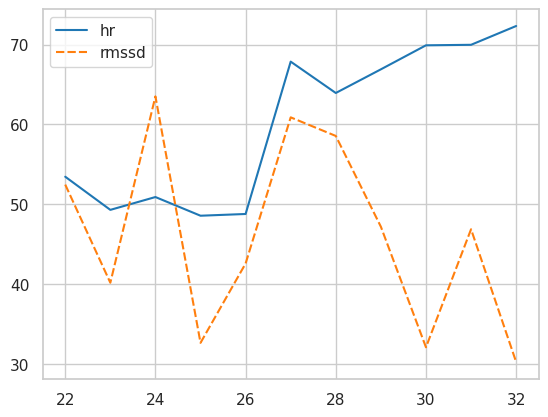

In [77]:
sns.lineplot(data=idx0_lastMeasurement[['hr', 'rmssd']])

Text(0.5, 1.0, 'Evening Measurement')

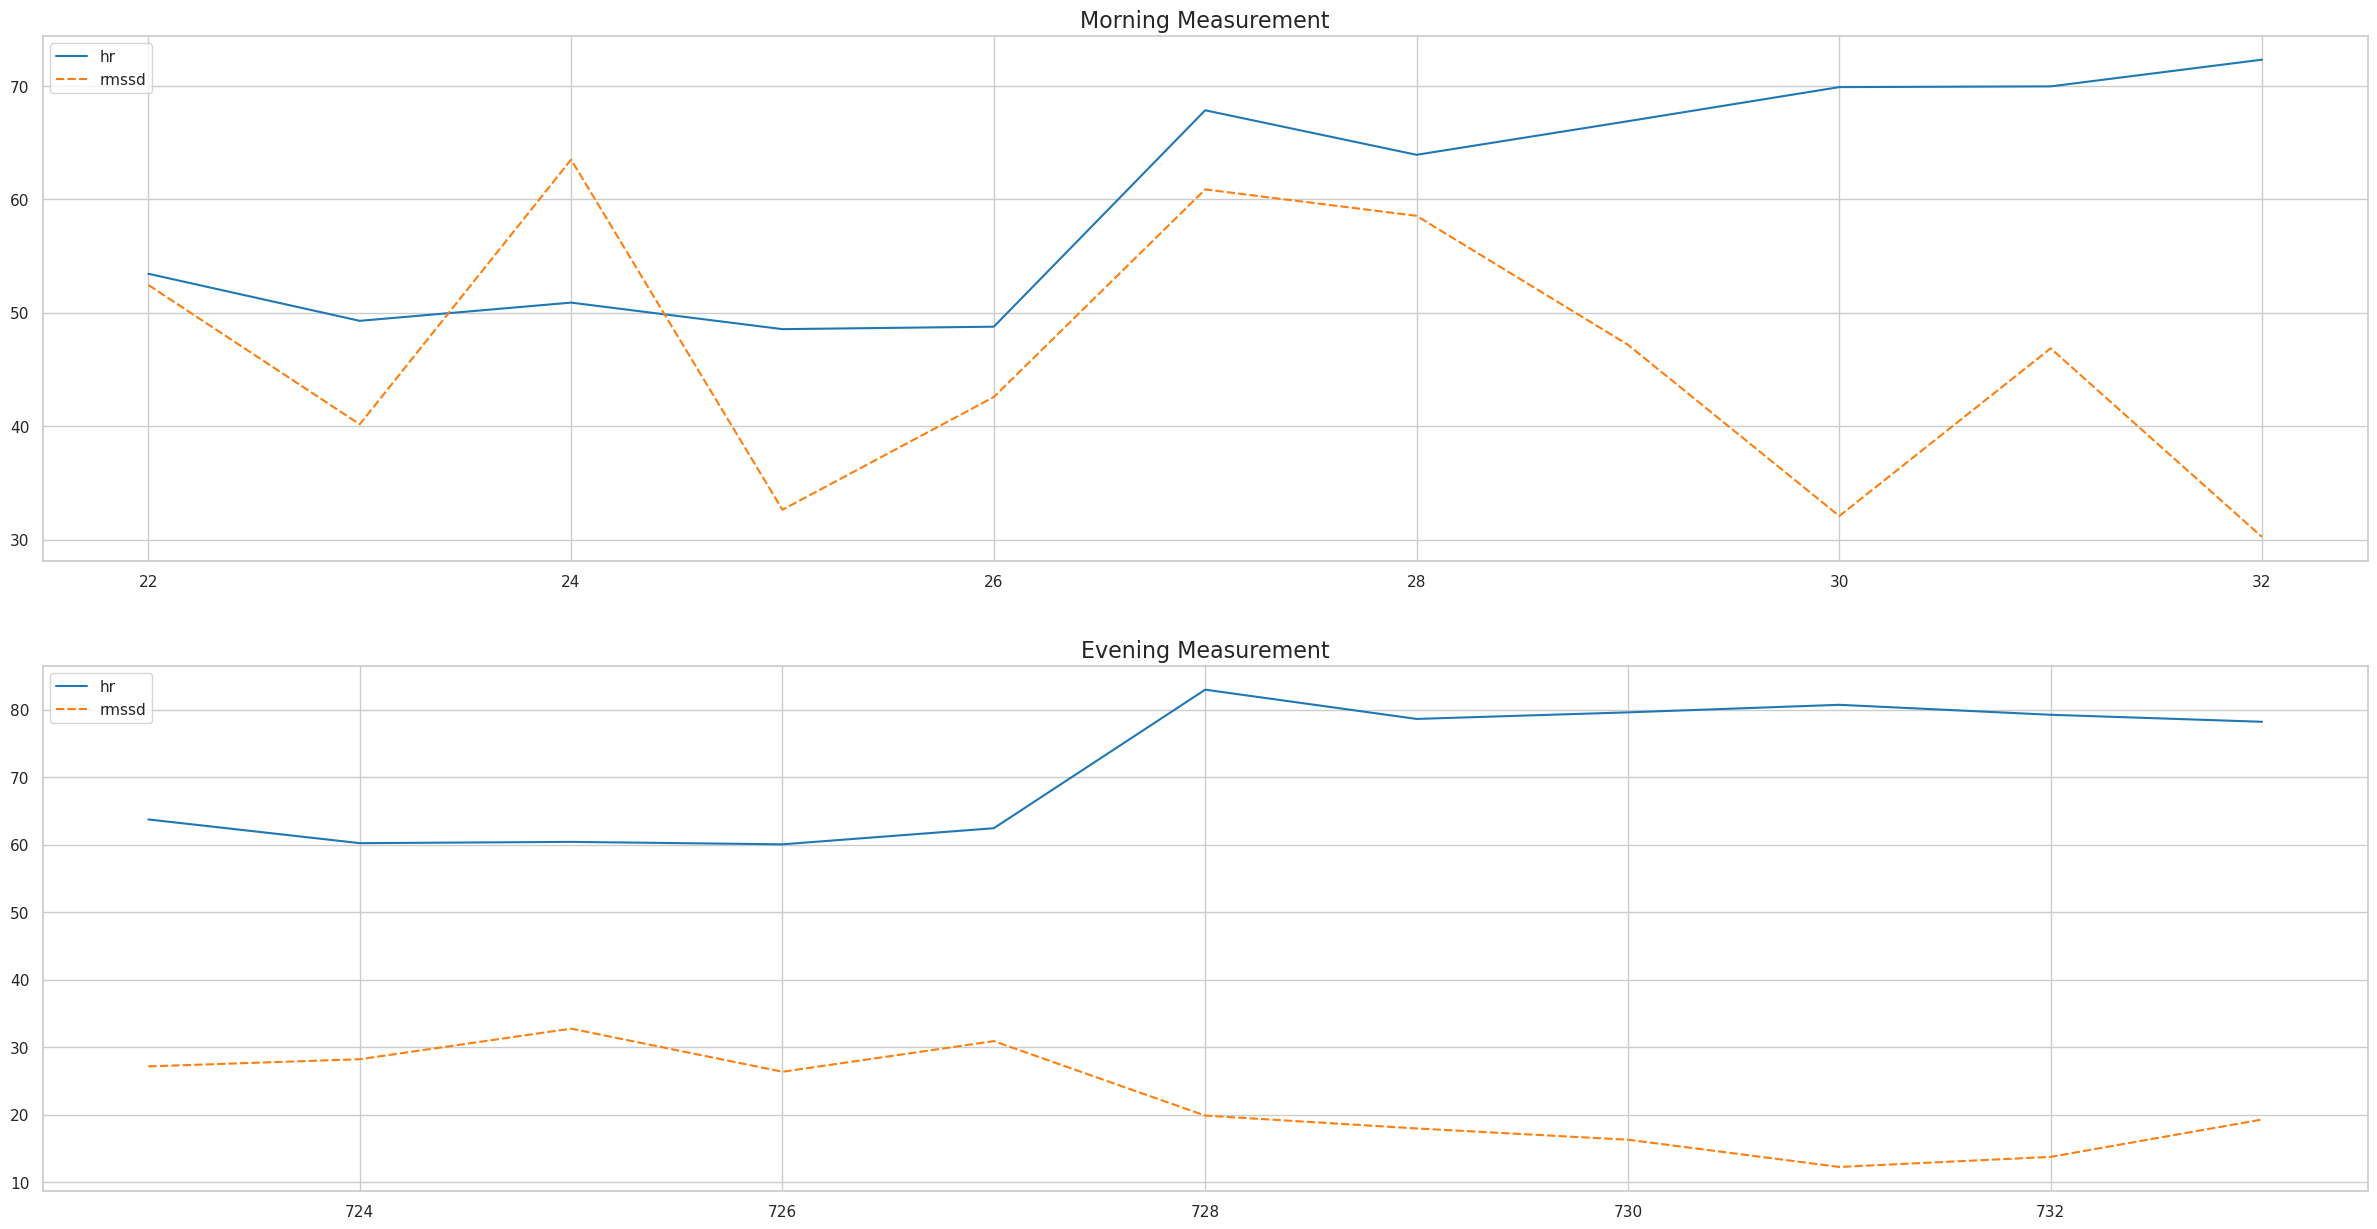

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,15) )

sns.lineplot(data=idx0_lastMeasurement[['hr', 'rmssd']],
             ax=axes[0])
sns.lineplot(data=idx1_lastMeasurement[['hr', 'rmssd']],
             ax=axes[1])
axes[0].set_title("Morning Measurement", fontsize=16)
axes[1].set_title("Evening Measurement", fontsize=16)


### Lineplot divided for morning/evening measurements
First overview, all measurements, group by measurement (date)

Text(0.5, 1.0, 'Heartrate')

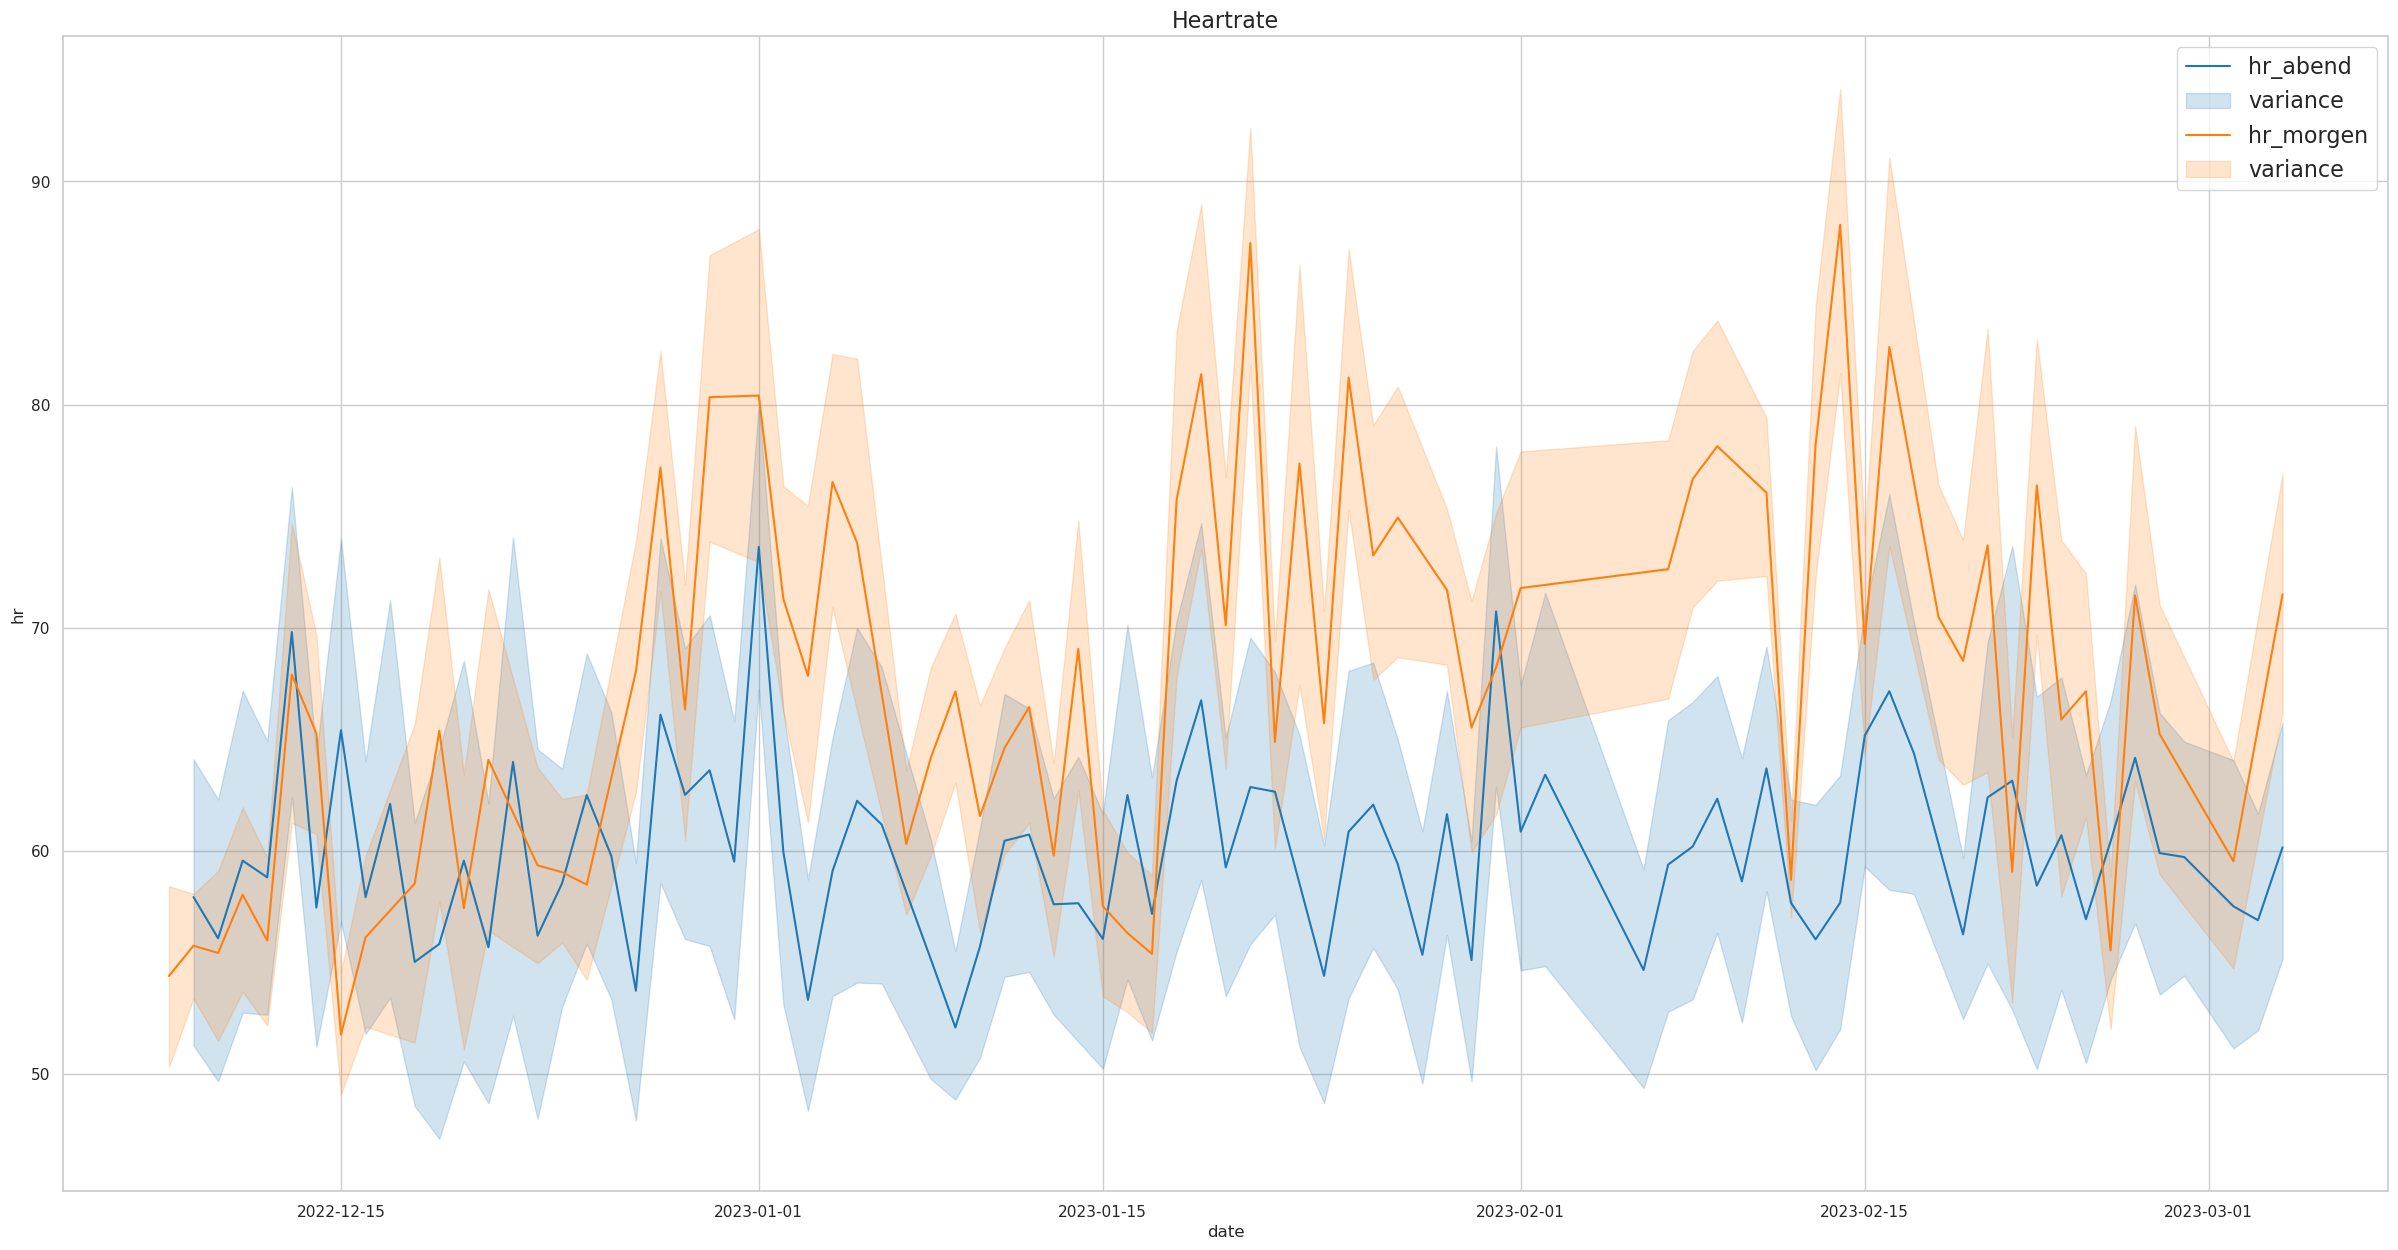

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,15) )

sns.lineplot(data=select_measurement_idx0,
             x='date',
             y='hr')
sns.lineplot(data=select_measurement_idx1,
             x='date',
             y='hr')
axes.legend(['hr_abend', 'variance', 'hr_morgen', 'variance'], fontsize=16)
axes.set_title("Heartrate", fontsize=16)

### Heatmap for all recorded data
See how all input measurements correlate

Text(0.5, 1.0, 'Evening Measurement')

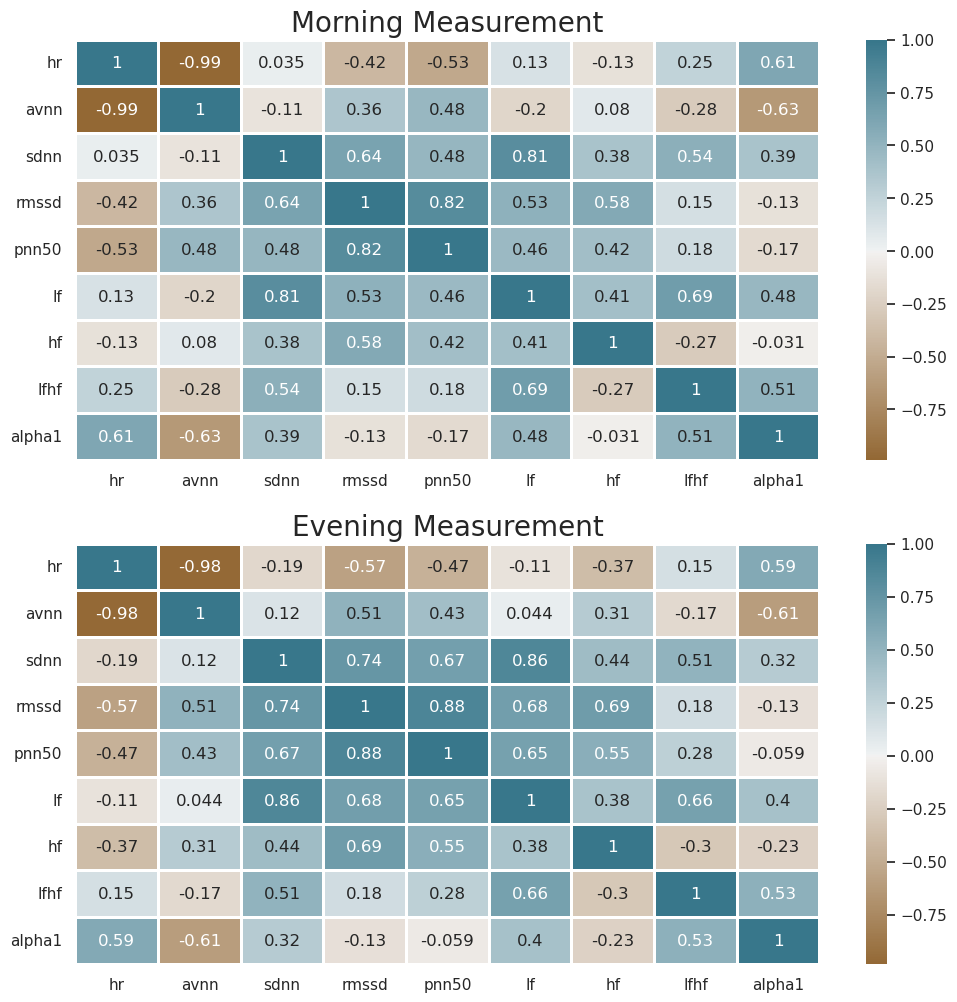

In [10]:
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                        figsize=(12,12))

# color palette
cmap = sns.diverging_palette(47, 221, l=47, s=77, as_cmap=True)

# morning measurements
sns.heatmap(corr_idx0.corr(),
            linewidths=1,
            center=0,
            cmap=cmap, 
            annot=True,
            ax=axes[0]
            )
axes[0].set_title('Morning Measurement', fontsize=20)

# evening measurements
sns.heatmap(corr_idx1.corr(),
            linewidths=1,
            center=0,
            cmap=cmap, 
            annot=True,
            ax=axes[1]
            )
axes[1].set_title('Evening Measurement', fontsize=20)

## Kde Plots for hr/rmssd values
Hr and Rmssd measurements are interesting
See how the values are distributed

In [11]:
df.head(3)

,datapoint,time,hr,avnn,sdnn,rmssd,pnn50,lf,hf,lfhf,alpha1,artifacts,measurement,date
0,0.0,2023-01-04 21:01:25.427,66.247508,905.694444,65.645859,40.970937,14.285714,0.091782,0.037117,2.472748,1.580302,0.0,ot_a28,2023-01-04
1,1.0,2023-01-04 21:01:54.594,65.132892,921.193548,57.668921,37.178507,10.000000,0.050631,0.030354,1.668019,1.120235,0.0,ot_a28,2023-01-04
2,2.0,2023-01-04 21:02:25.331,66.834283,897.742857,50.971893,37.439244,11.764706,0.042526,0.049673,0.856119,1.426409,0.0,ot_a28,2023-01-04


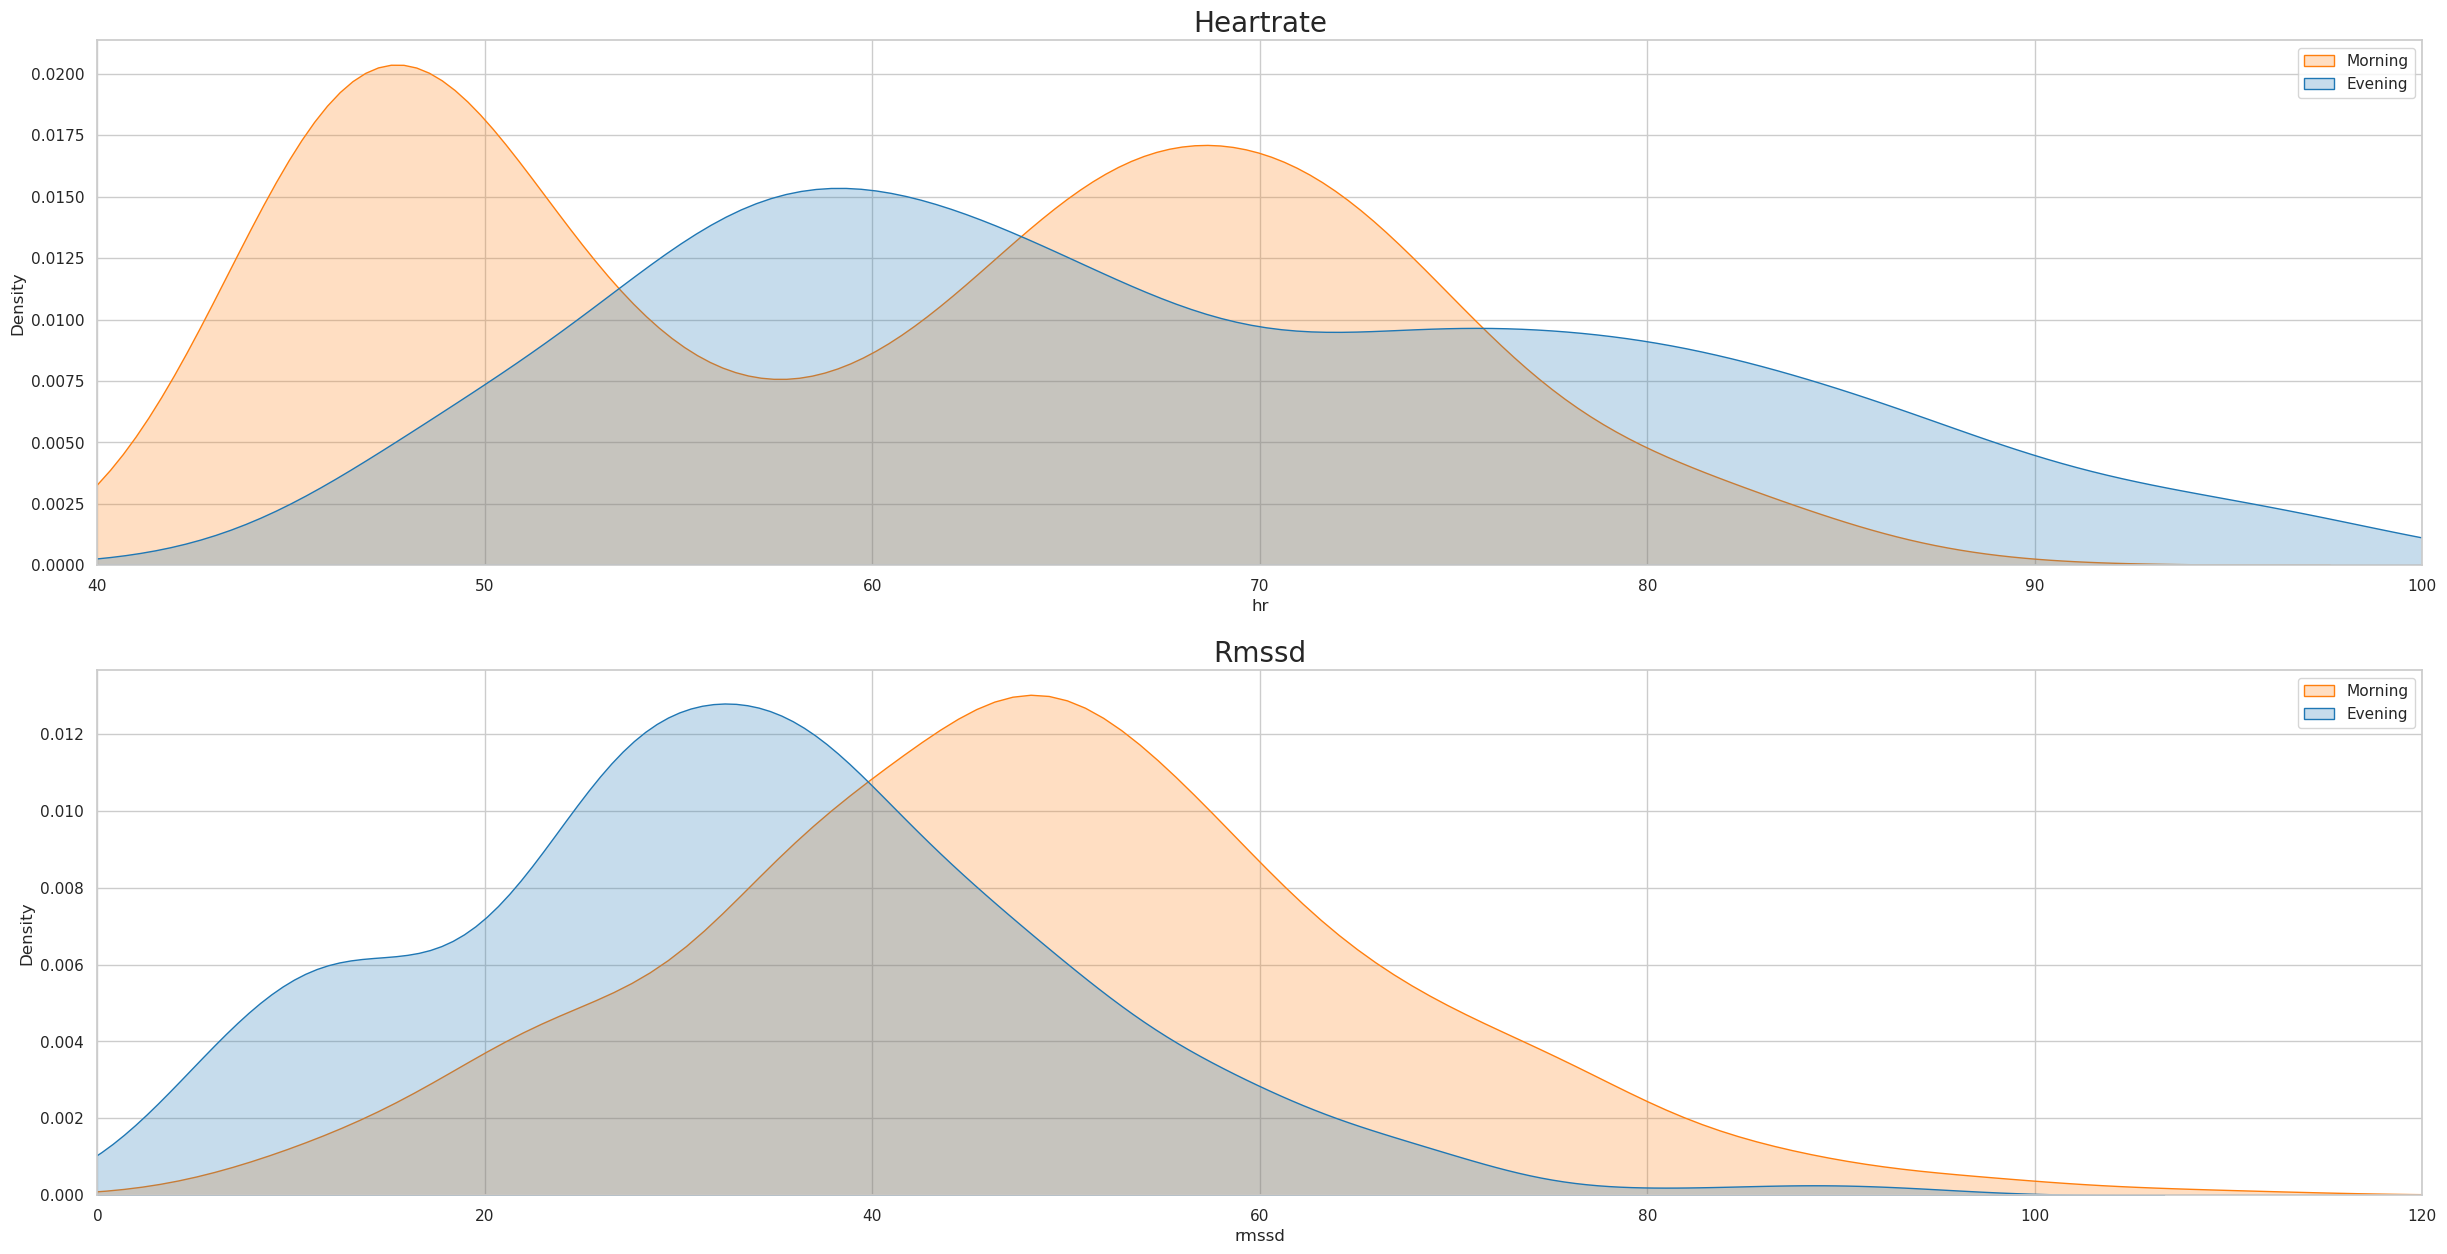

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,15))
sns.kdeplot(data=df,
            x='hr',
            hue=df['measurement'].str[:4],
            fill=True,
            ax=axes[0])
axes[0].set_title('Heartrate', fontsize=20)
axes[0].set_xlim(40, 100)
axes[0].legend(labels = ['Morning', 'Evening'])

sns.kdeplot(data=df,
            x='rmssd',
            hue=df['measurement'].str[:4],
            fill=True,
            ax=axes[1])
axes[1].set_title('Rmssd', fontsize=20)
axes[1].set_xlim(0, 120)
axes[1].legend(labels = ['Morning', 'Evening'])

## Histogram Plots
Distribution of hr/rmssd values per measurement setting

(5.0, 100.0)

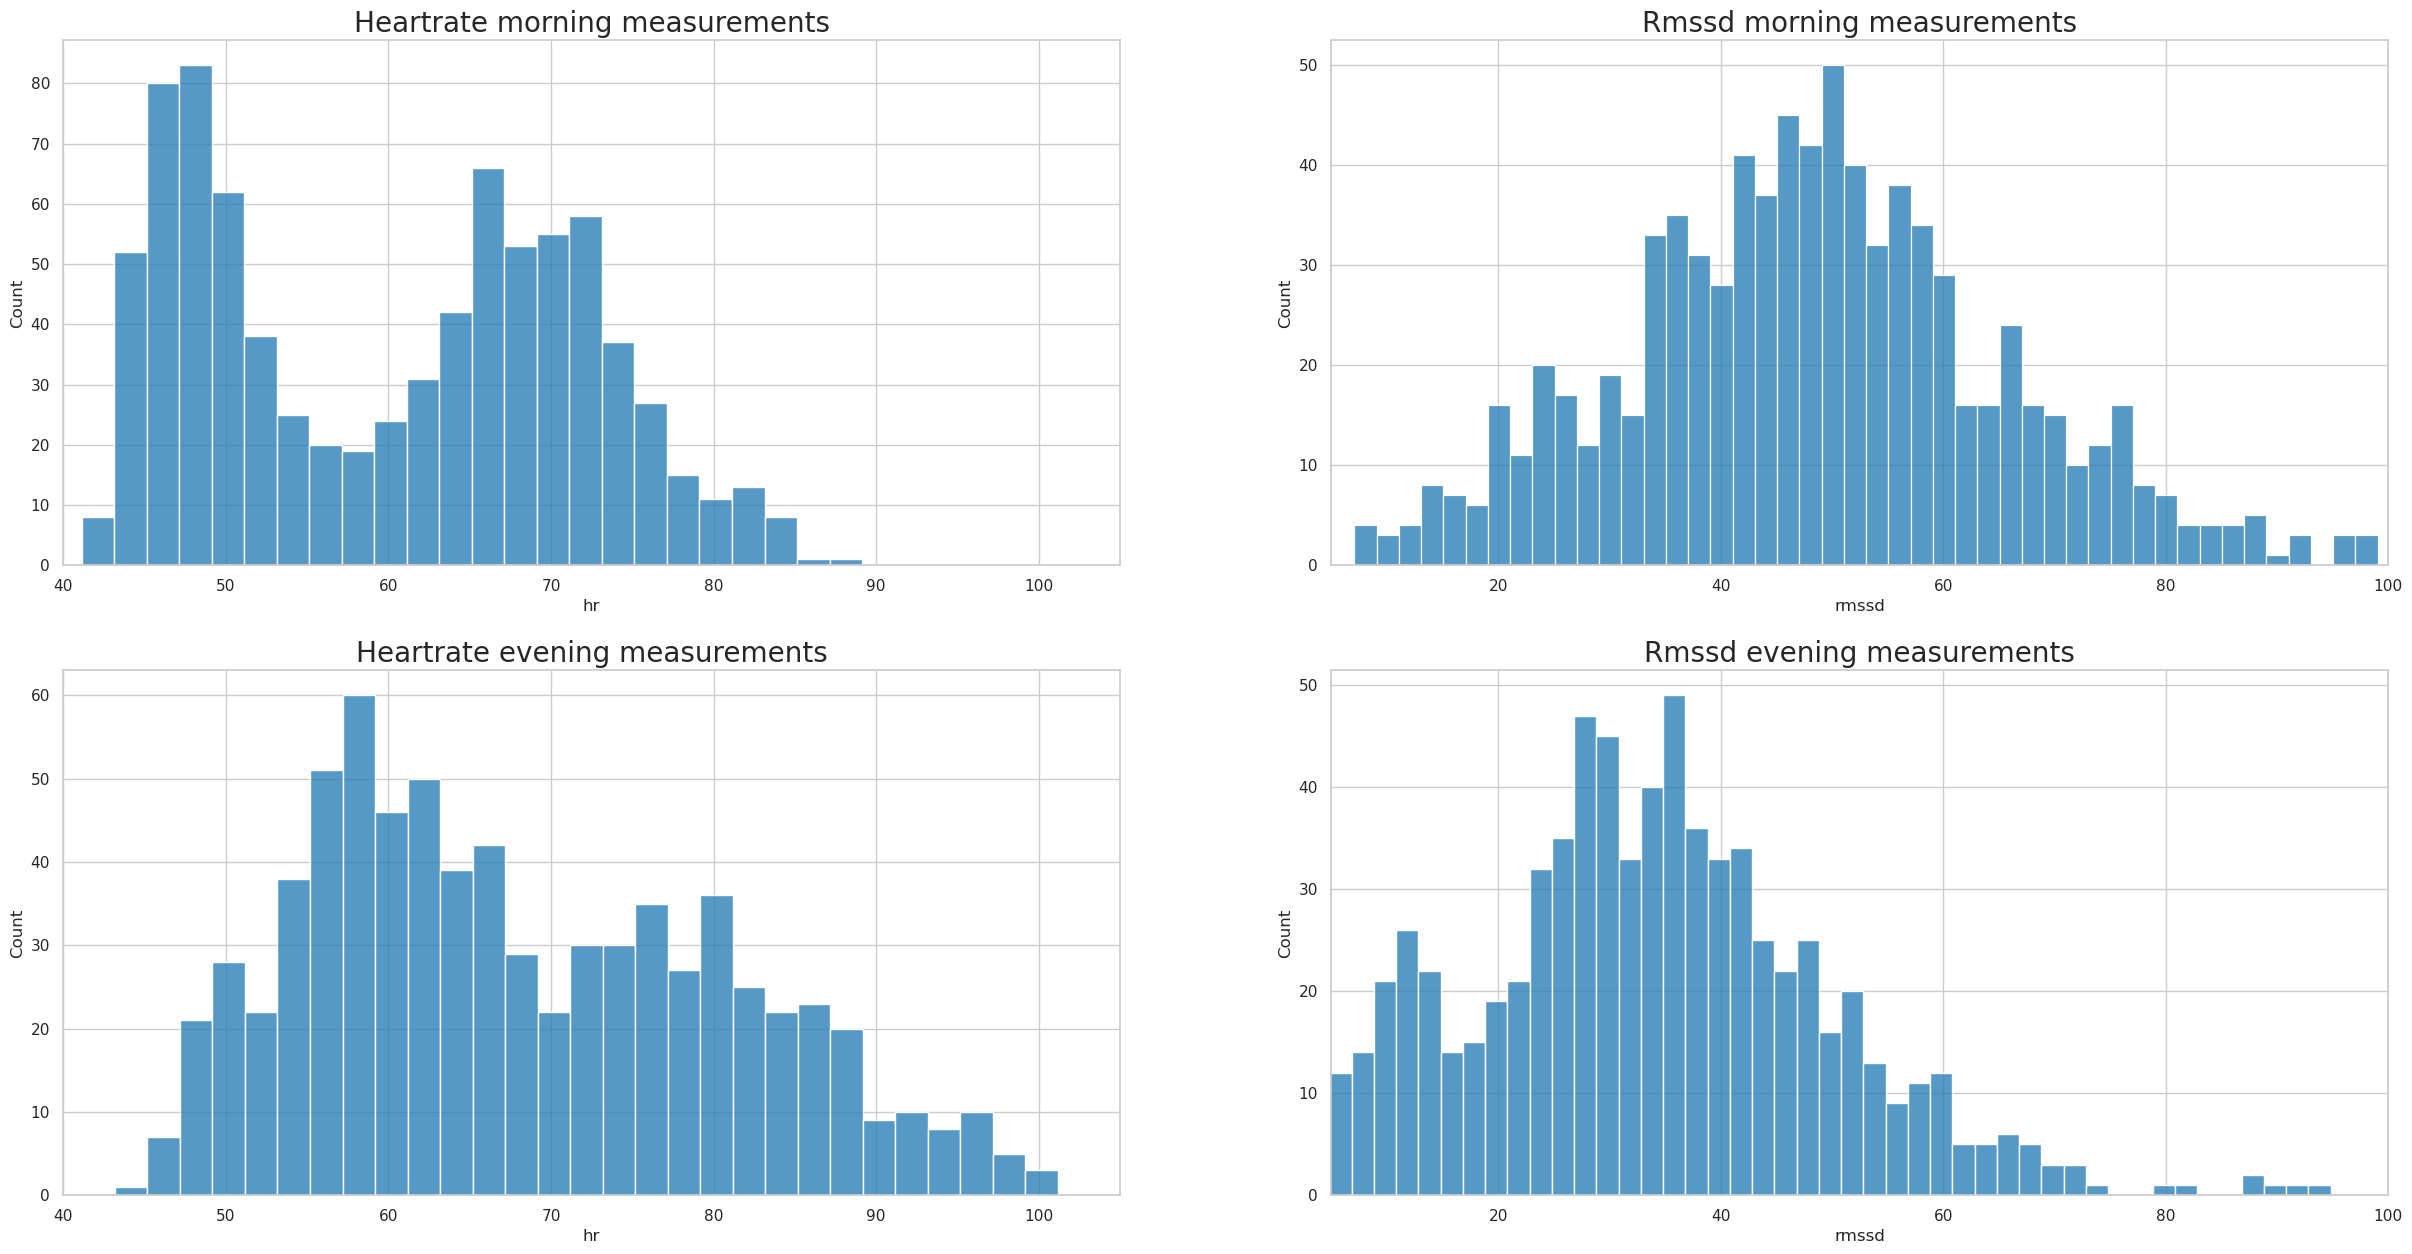

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,15))

# morning measurements
sns.histplot(data=select_measurement_idx0, 
             x='hr', 
             binwidth=2, 
             ax=axes[0, 0]
             )
axes[0, 0].set_title('Heartrate morning measurements', fontsize=20)
axes[0, 0].set_xlim(40, 105)

sns.histplot(data=select_measurement_idx0, 
             x='rmssd', 
             binwidth=2, 
             ax=axes[0, 1]
             )
axes[0, 1].set_title('Rmssd morning measurements', fontsize=20)
axes[0, 1].set_xlim(5, 100)

# evening measurements
sns.histplot(data=select_measurement_idx1, 
             x='hr', 
             binwidth=2, 
             ax=axes[1, 0]
             )
axes[1, 0].set_title('Heartrate evening measurements', fontsize=20)
axes[1, 0].set_xlim(40, 105)

sns.histplot(data=select_measurement_idx1, 
             x='rmssd', 
             binwidth=2, 
             ax=axes[1, 1]
             )
axes[1, 1].set_title('Rmssd evening measurements', fontsize=20)
axes[1, 1].set_xlim(5, 100)

# Output for obsidian myHealth
Generate image file for Obsidian myHealth input

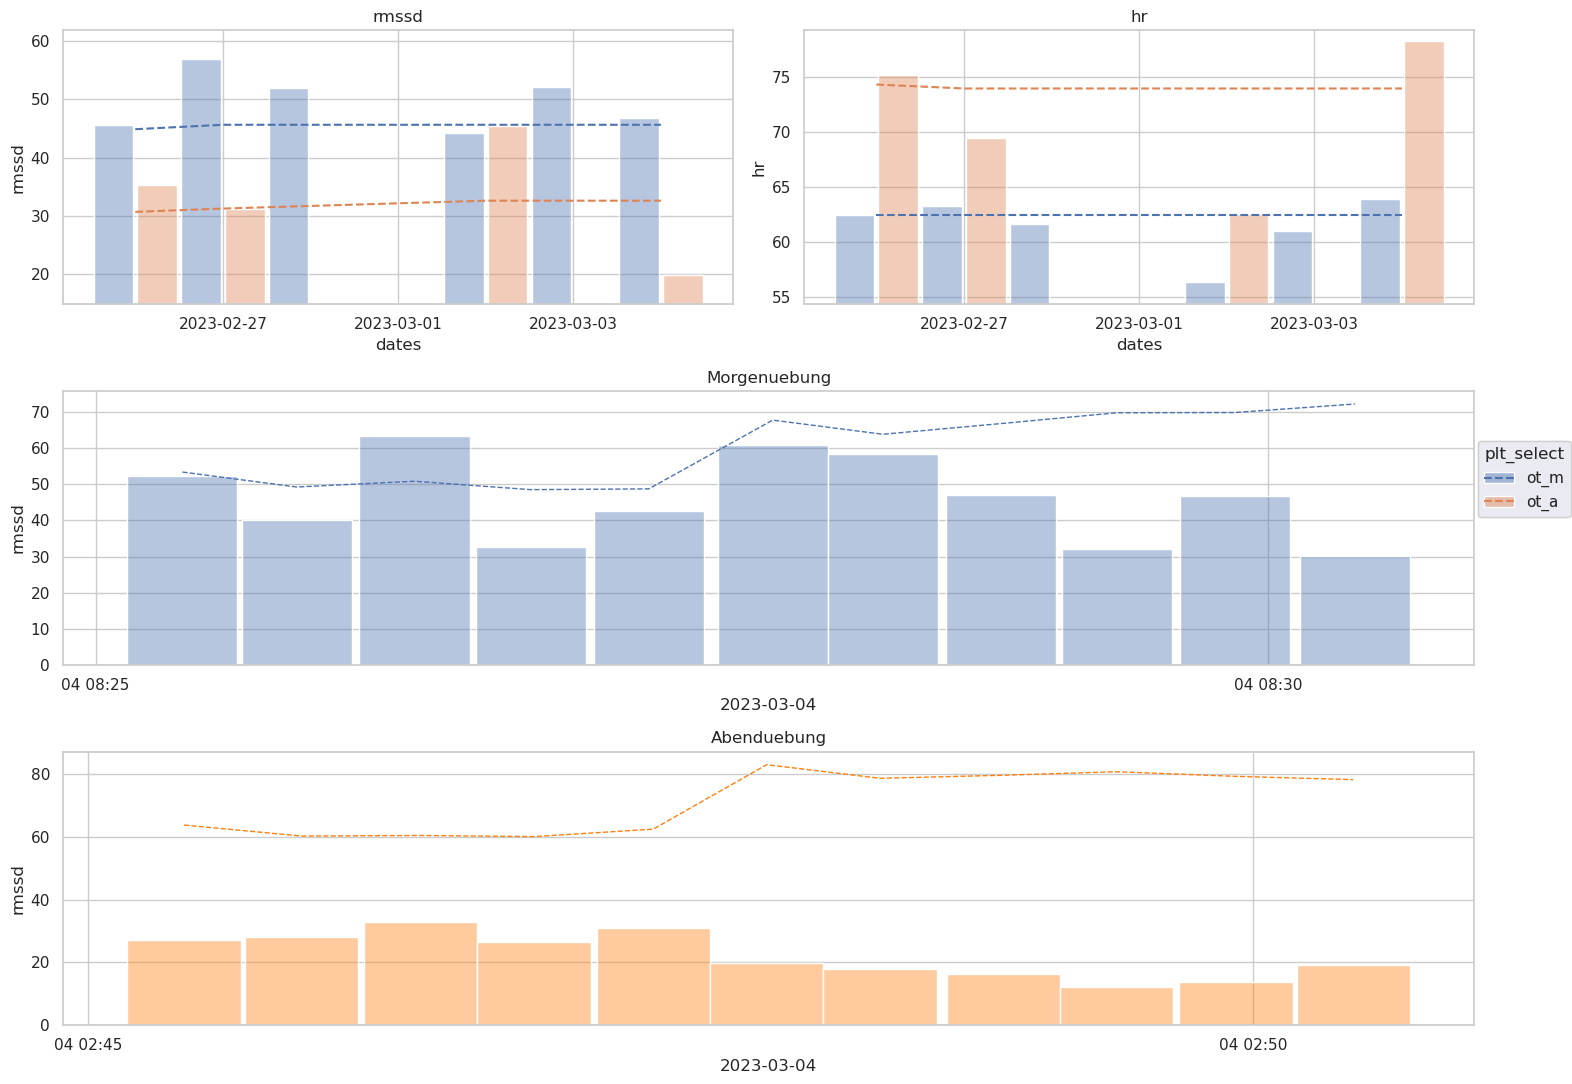

In [ ]:
import matplotlib.dates as mdates

plt.close('all')
fig = plt.figure(figsize=(15,11))

# define grid and plot windows in main grid
sf1 = plt.subplot2grid((3,2), (0,0))    #links oben
sf2 = plt.subplot2grid((3,2), (0,1))    #rechts oben
sf3 = plt.subplot2grid((3,2), (1,0), colspan=2)
sf4 = plt.subplot2grid((3,2), (2,0), colspan=2)

# create plots with seaborn object interface
(
    so.Plot(plt_df,
            y='rmssd',
            x='date',
            color= 'plt_select')
    .add(so.Bars(alpha= 0.4), 
         so.Agg('median'), 
         so.Dodge(gap=.1))  # type: ignore
    .add(so.Line(linestyle= '--'), y= 'rol_rmssd')
    .label(title= 'rmssd',
           x= 'dates')
    .limit(y= (plt_df['rmssd'].min()-5, plt_df['rmssd'].max()+5))          
    .on(sf1)
    .plot()
)

(
    so.Plot(plt_df,
            y='hr',
            x='date',
            color= 'plt_select')
    .add(so.Bars(alpha= 0.4),
         so.Agg('median'), 
         so.Dodge(gap=.1))  # type: ignore
    .add(so.Line(linestyle= '--'), y= 'rol_hr')
    .label(title= 'hr',
           x= 'dates')
    .limit(y= (plt_df['hr'].min()-2, plt_df['hr'].max()+1))
    .on(sf2)
    .plot()
)

(
    so.Plot(select_measurement_idx0[select_measurement_idx0['date'] == max(select_measurement_idx0['date'])],
            y='rmssd',
            x='time',)
    .add(so.Bars(alpha= 0.4), 
         so.Agg('median'))
    .add(so.Line(linestyle= '--', linewidth= 1,), y= 'hr')
    .label(title= 'Morgenuebung',
           x= max(select_measurement_idx0['date']).date())
    .on(sf3)
    .plot()
)

(
    so.Plot(select_measurement_idx1[select_measurement_idx1['date'] == max(select_measurement_idx1['date'])],
            y='rmssd',
            x='time',)
    .add(so.Bars(alpha= 0.4, color= '#ff7f0e'), 
         so.Agg('median'))
    .add(so.Line(linestyle= '--', linewidth= 1, color= '#ff7f0e'), y= 'hr')
    .label(title= 'Abenduebung',
           x= max(select_measurement_idx1['date']).date())
    .on(sf4)
    .plot()
)
plt.tight_layout()